# Global PAth vars

In [1]:
#PATH 
base_path = "drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Dataset/Alzheimers_Dataset/"
train = f"{base_path}train/"
test = f"{base_path}test/"
Save = f"drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Visualisation/"


base_path_bin = "drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Dataset/Alzheimers_Dataset_Binary/"
train_bin = f"{base_path_bin}train/" 
test_bin = f"{base_path_bin}test/"
Save_bin = f"drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Visualisation/BinaryClassification/"

# Imports

In [2]:
import os, time

#arr operations
import numpy as np

# Progress Bar
from tqdm import tqdm

# Evaluation metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

#Importing Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D
from keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback, ReduceLROnPlateau
from keras import optimizers, Input
from keras.utils.vis_utils import plot_model
from keras.applications.imagenet_utils import decode_predictions
import keras.backend as K


#Pretrained models
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from keras.applications.resnet_v2 import ResNet152V2
#from keras.applications.resnet152_v2 import ResNet152V2


#Image read and show
import skimage.io
from skimage.io import imread, imshow
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')

#Metrics
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle


In [3]:
tf.__version__

'2.8.2'

# Utils Functions

In [4]:
def Confusion_Matrix_Heatmap(y_test,y_pred,class_Names, fName, ModelName):
    #Plot the confusion matrix to understand the classification in detail
    CM = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    ax = sns.heatmap(CM, cmap='Greens', annot=True, fmt='d', xticklabels=class_Names, yticklabels=class_Names)
    plt.title(f'Alzheimer\'s Disease Diagnosis - {ModelName}')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.savefig(f"{Save}{fName}")
    #plt.show(ax)

# Plot Evaluation Metrics
sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')
def Eval_Plot(acc,val_acc, loss,val_loss, auc, val_auc, precision, val_precision, path, title):
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(f"{title}\n", fontsize = 15)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize = 15)
    ax1.set_xlabel('Epochs', fontsize = 15)
    ax1.set_ylabel('Accuracy', fontsize = 15)
    ax1.legend(['Training', 'Validation'], fontsize = 15)


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize = 15)
    ax2.set_xlabel('Epochs', fontsize = 15)
    ax2.set_ylabel('Loss', fontsize = 15)
    ax2.legend(['Training', 'Validation'], fontsize = 15)

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC', fontsize = 15)
    ax3.set_xlabel('Epochs', fontsize = 15)
    ax3.set_ylabel('AUC', fontsize = 15)
    ax3.legend(['Training', 'Validation'], fontsize = 15)
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision', fontsize = 15)
    ax4.set_xlabel('Epochs', fontsize = 15)
    ax4.set_ylabel('Precision', fontsize = 15)
    ax4.legend(['Training', 'Validation'], fontsize = 15)

    plt.savefig(f"{Save}{path}")
    #plt.show()

def freeze_BN(model):
  """
  Unfreeze all layers except BatchNorm
  """
  for layer in model.layers:
    if isinstance(layer, BatchNormalization):
      layer.trainable = False

# Model Building 

## Set Seed

In [5]:
Seed = 29
Batch_Size = 32
Image_Size = 224
np.random.seed(Seed)
tf.random.set_seed(Seed)

## GPU Test

In [6]:
# GPU
tf.test.gpu_device_name()

'/device:GPU:0'

# MULTICLASS CLASSIFICATION MODELS

## Data Generator 

In [7]:
# Image data generator
training_data_gen = ImageDataGenerator(
    validation_split = 0.2,
    preprocessing_function=keras.applications.resnet_v2.preprocess_input,           
    )

testing_data_gen = ImageDataGenerator(        
    preprocessing_function=keras.applications.resnet_v2.preprocess_input,           
    )

validation_data_gen = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet_v2.preprocess_input,
    validation_split = 0.2
    )

## Splitting the Data

In [8]:
training_data = training_data_gen.flow_from_directory(
    directory= train,
    target_size = (Image_Size,Image_Size),
    class_mode = 'categorical',
    color_mode  = 'rgb', 
    subset = 'training',
    seed = Seed,
    batch_size = Batch_Size)

validation_data = validation_data_gen.flow_from_directory(
  directory = train,
  target_size = (Image_Size,Image_Size),
  class_mode = 'categorical',
  color_mode  = 'rgb', 
  subset = 'validation',
  seed = Seed,
  batch_size = Batch_Size)

testing_data =  testing_data_gen.flow_from_directory(
  directory = test,
  target_size = (Image_Size,Image_Size),
  class_mode = 'categorical',
  color_mode  = 'rgb', 
  seed = Seed,
  batch_size = Batch_Size
)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [9]:
ClassName2Ind = (training_data.class_indices)
Ind2ClassName = {v: k for k, v in ClassName2Ind.items()}
X,y = training_data.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'NonDemented')

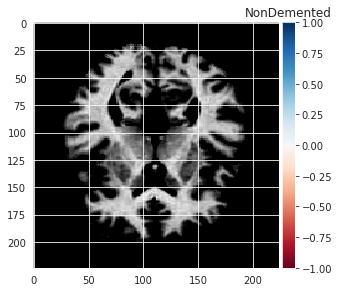

In [10]:
imshow(X[0])
plt.title(Ind2ClassName[np.argmax(y[0],axis=0)])

In [11]:
steps_per_epoch = training_data.n // training_data.batch_size
print('steps per epoch: ',steps_per_epoch)

steps per epoch:  128


In [12]:
assert len(training_data) > 5, "Less Than 5 Batches"
assert len(validation_data) > 5, "Less Than 5 Batches"
assert len(testing_data) > 5, "Less Than 5 Batches"

In [13]:
print(f"Train shape : {X.shape} y shape {y.shape}")

Train shape : (32, 224, 224, 3) y shape (32, 4)


## ResNet152V2

In [14]:
ResNet152V2_base = ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=(Image_Size,Image_Size,3),
)

ResNet152V2_base.trainable = False

234561536/234545216 [==============================] - 1s 0us/step


In [15]:
for layer in ResNet152V2_base.layers:
    layer.trainable=False

In [16]:
# Building Top
ResNet152V2_Top=Sequential()
ResNet152V2_Top.add(ResNet152V2_base)
ResNet152V2_Top.add(BatchNormalization())
ResNet152V2_Top.add(Conv2D(1024,3,padding='same',activation='relu'))
ResNet152V2_Top.add(Conv2D(1024,3,padding='same',activation='relu'))
ResNet152V2_Top.add(MaxPooling2D())
ResNet152V2_Top.add(Dropout(0.60))
ResNet152V2_Top.add(BatchNormalization())
ResNet152V2_Top.add(Flatten())
ResNet152V2_Top.add(Dense(1024,activation='relu'))
ResNet152V2_Top.add(Dense(4,activation='softmax'))

In [17]:
ResNet152V2_Top.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 1024)        18875392  
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 1024)        9438208   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 1024)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 3, 3, 1024)        0

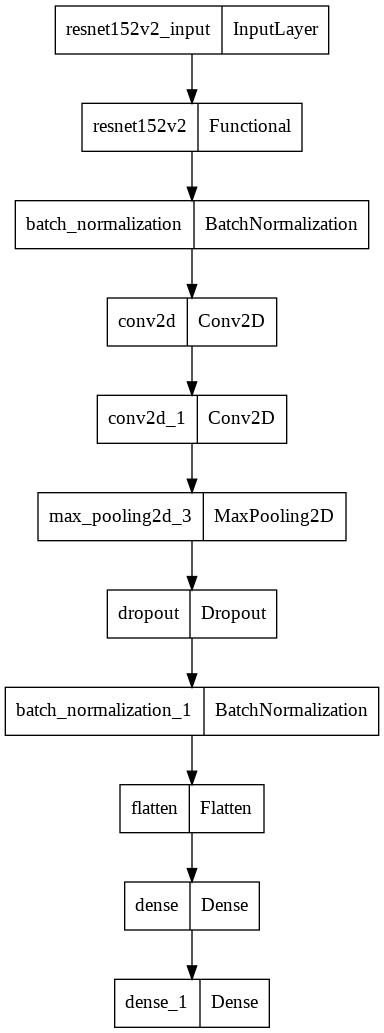

In [18]:
plot_model(
    ResNet152V2_Top,
    to_file=f"{Save}ResNet152V2/Architecture.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)


### ResNet152V2 Transfer Learning - Freeze base model

In [19]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),  
      keras.metrics.AUC(name='auc')
]

ResNet152V2_Top.compile(
    optimizer=keras.optimizers.Adam(0.001), 
    loss='categorical_crossentropy',
    metrics=METRICS,
    )
epochs = 20
ResNet152V2_history_1 = ResNet152V2_Top.fit(
    training_data, 
    epochs=epochs, 
    validation_data=validation_data,
    steps_per_epoch=steps_per_epoch,
    verbose = 1,
    )

Epoch 1/20
128/128 [==============================] - 484s 4s/step - loss: 1.3548 - accuracy: 0.7688 - precision: 0.5732 - recall: 0.2937 - auc: 0.7841 - val_loss: 1.1608 - val_accuracy: 0.7608 - val_precision: 0.5241 - val_recall: 0.4673 - val_auc: 0.7953
Epoch 2/20
128/128 [==============================] - 25s 194ms/step - loss: 0.8918 - accuracy: 0.7990 - precision: 0.6822 - recall: 0.3669 - auc: 0.8468 - val_loss: 1.0792 - val_accuracy: 0.7617 - val_precision: 0.5656 - val_recall: 0.2023 - val_auc: 0.7545
Epoch 3/20
128/128 [==============================] - 25s 194ms/step - loss: 0.7833 - accuracy: 0.8167 - precision: 0.6952 - recall: 0.4747 - auc: 0.8814 - val_loss: 1.6301 - val_accuracy: 0.6307 - val_precision: 0.2258 - val_recall: 0.1965 - val_auc: 0.6309
Epoch 4/20
128/128 [==============================] - 25s 194ms/step - loss: 0.6205 - accuracy: 0.8642 - precision: 0.7519 - recall: 0.6820 - auc: 0.9293 - val_loss: 1.3272 - val_accuracy: 0.7163 - val_precision: 0.4245 - val

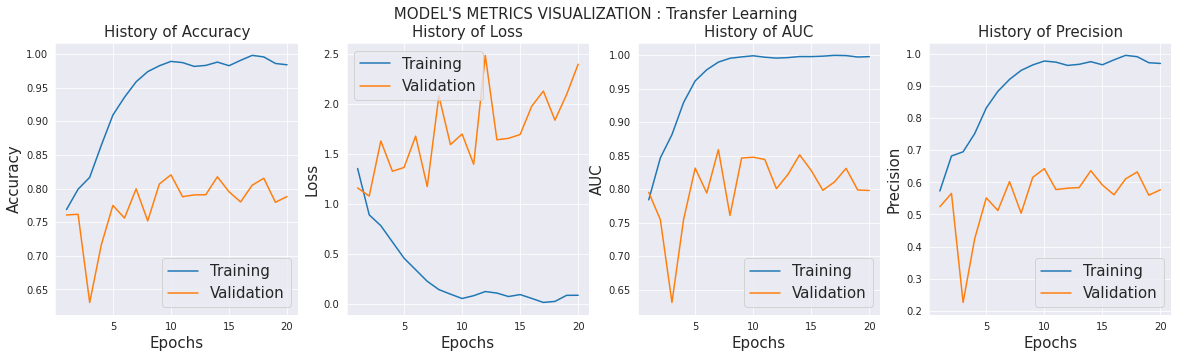

In [20]:
path = "ResNet152V2/loss_acc_1.png"
title = " MODEL'S METRICS VISUALIZATION : Transfer Learning "
Eval_Plot(
    ResNet152V2_history_1.history['accuracy'],ResNet152V2_history_1.history['val_accuracy'],
    ResNet152V2_history_1.history['loss'],ResNet152V2_history_1.history['val_loss'],
    ResNet152V2_history_1.history['auc'],ResNet152V2_history_1.history['val_auc'],
    ResNet152V2_history_1.history['precision'],ResNet152V2_history_1.history['val_precision'],
    path, title
)

### ResNet152V2 finetuning - Unfreeze base model and train entire model with low learning rate

In [21]:
isinstance(ResNet152V2_base.layers[1], BatchNormalization)

False

In [22]:
ResNet152V2_base.trainable = True
#freeze_BN(ResNet152V2_base)

In [23]:
epochs = 50
lr_reduce = ReduceLROnPlateau(monitor='val_auc', factor=0.6, patience=5, verbose=1, mode='max', min_lr=5e-5)

early_stopping_cb = EarlyStopping(
    monitor='val_auc', 
    patience=10, 
    restore_best_weights=True, 
    verbose=1, 
    mode="max"
    )

checkpoint_cb = ModelCheckpoint(
    f"{Save}ResNet152V2/ResNet152V2.h5", 
    monitor='val_auc',
    save_best_only=True, 
    verbose=1, 
    mode="max"
    )

ResNet152V2_Top.compile(
    optimizer=keras.optimizers.RMSprop(0.001),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=METRICS,
)

ResNet152V2_Top.summary()

ResNet152V2_history_2 = ResNet152V2_Top.fit(
    training_data, 
    epochs=epochs, 
    validation_data=validation_data, 
    verbose = 1, 
    steps_per_epoch=steps_per_epoch,
    callbacks = [lr_reduce, early_stopping_cb, checkpoint_cb],
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 1024)        18875392  
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 1024)        9438208   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 1024)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 3, 3, 1024)        0

### Scores

In [24]:
scores_ResNet152V2 = ResNet152V2_Top.evaluate(testing_data)

40/40 [==============================] - 213s 5s/step - loss: 5.8560 - accuracy: 0.8006 - precision: 0.6025 - recall: 0.5950 - auc: 0.8302


In [25]:
print(f"Accuracy in test set  : {scores_ResNet152V2[1]}")
print(f"Precision in test set : {scores_ResNet152V2[2]}")
print(f"Recall in test set    : {scores_ResNet152V2[3]}")
print(f"AUC in test set       : {scores_ResNet152V2[4]}")

Accuracy in test set  : 0.8006255030632019
Precision in test set : 0.6025336384773254
Recall in test set    : 0.5949960947036743
AUC in test set       : 0.8301635384559631


In [26]:
import pandas as pd
Scores = pd.DataFrame([scores_ResNet152V2], columns = ["Loss", "Test Accuracy", "Precision", "Recall", "AUC"])
Scores


,Loss,Test Accuracy,Precision,Recall,AUC
0,5.856023,0.800626,0.602534,0.594996,0.830164


In [27]:
Scores.to_csv(f"{Save}ResNet152V2/score.csv")

### Plots 

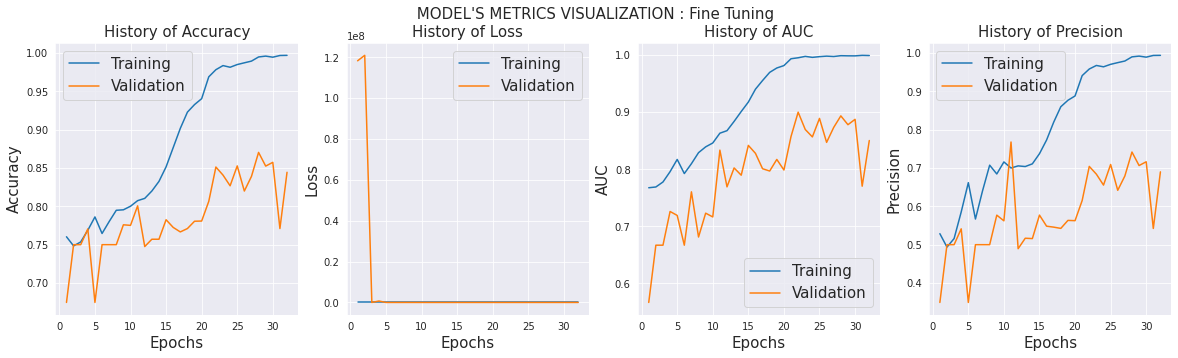

In [28]:
path = "ResNet152V2/loss_acc_2.png"
title = " MODEL'S METRICS VISUALIZATION : Fine Tuning "
Eval_Plot(
    ResNet152V2_history_2.history['accuracy'],ResNet152V2_history_2.history['val_accuracy'],
    ResNet152V2_history_2.history['loss'],ResNet152V2_history_2.history['val_loss'],
    ResNet152V2_history_2.history['auc'],ResNet152V2_history_2.history['val_auc'],
    ResNet152V2_history_2.history['precision'],ResNet152V2_history_2.history['val_precision'],
    path, title
)

In [29]:
predictions = ResNet152V2_Top.predict(testing_data) 
y_pred = predictions.argmax(axis = -1)
y_label = testing_data.labels.copy()
class_Names = list(testing_data.class_indices.keys())

In [30]:
assert y_pred.shape == y_label.shape

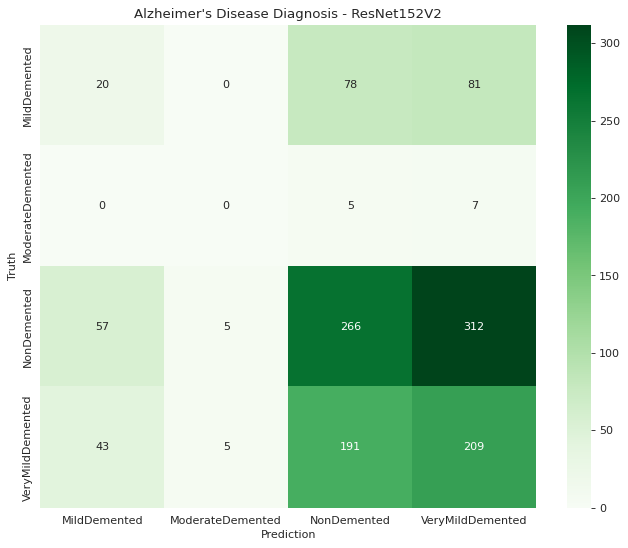

In [31]:
Confusion_Matrix_Heatmap(y_label, y_pred, class_Names, f"ResNet152V2/HeatMap.jpeg", "ResNet152V2")

# GradCam, activation Visualisation

In [32]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Configurable parameters

In [33]:
ResNet152V2_Top.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 1024)        18875392  
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 1024)        9438208   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 1024)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 3, 3, 1024)        0

In [34]:
last_conv_layer_name = "conv2d_1"
decode_predictions = keras.applications.inception_v3.decode_predictions
X,y = testing_data.next()

In [35]:
X[3].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


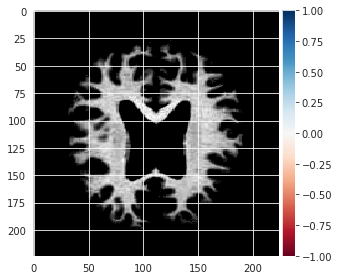

In [36]:
img_path = X[0].copy()
imshow(X[3])

In [37]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our image array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_gradcam_img(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img


In [38]:
# Make model
model_load= keras.models.load_model(f"{Save}ResNet152V2/ResNet152V2.h5")

# Remove last layer's softmax
model_load.layers[-1].activation = None

In [45]:
class_Names = os.listdir(f"{test}").copy()
img_paths = []
for cls in class_Names:
  ClsPath2dir = f"{test}{cls}/"
  content = os.listdir(ClsPath2dir)
  imgPath = os.path.join(ClsPath2dir, np.random.choice(content))
  img_paths.append(imgPath)

img_paths


['drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Dataset/Alzheimers_Dataset/test/ModerateDemented/28.jpg',
 'drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Dataset/Alzheimers_Dataset/test/VeryMildDemented/31 (41).jpg',
 'drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Dataset/Alzheimers_Dataset/test/NonDemented/32 (4).jpg',
 'drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Dataset/Alzheimers_Dataset/test/MildDemented/29 (22).jpg']

Predicted : ModerateDemented
Predicted : VeryMildDemented
Predicted : NonDemented
Predicted : VeryMildDemented


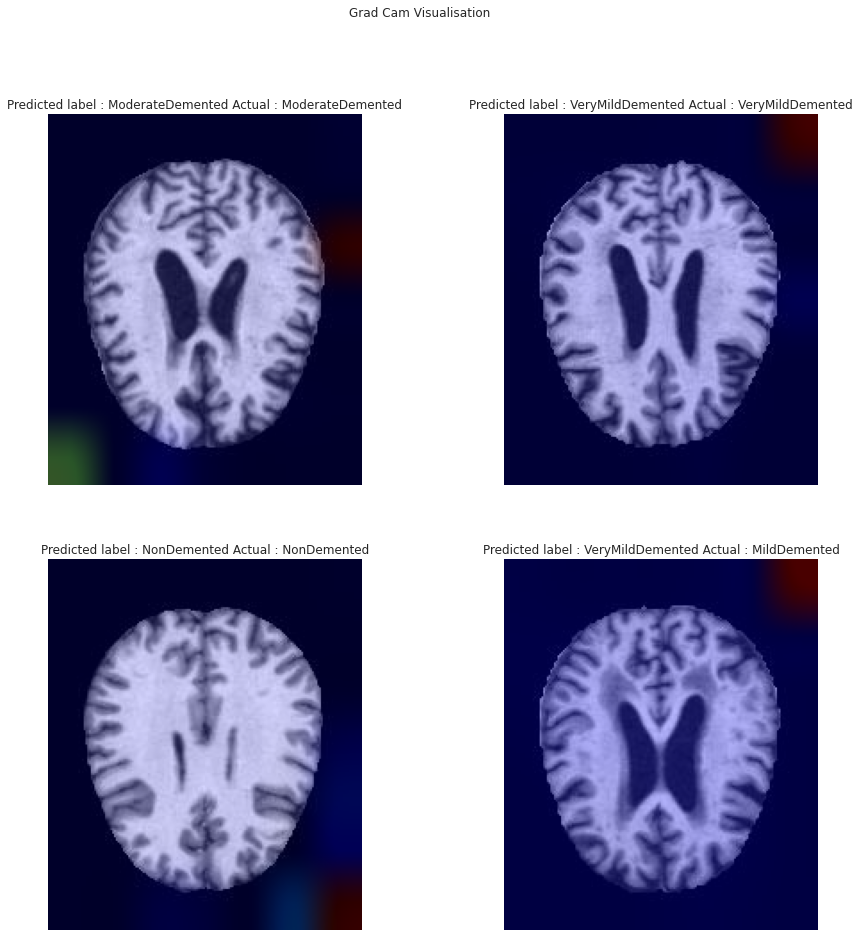

In [46]:
fig, axs = plt.subplots(2, 2, figsize = (15,15))
for ax, path, label in zip(axs.flatten(), img_paths, class_Names): 
  # Prepare image
  img_arry = keras.applications.resnet_v2.preprocess_input(get_img_array(path, (Image_Size, Image_Size)))
  # Print what the top predicted class is
  preds = model_load.predict(img_arry)
  print(f"Predicted : {Ind2ClassName[int(preds.argmax(axis=-1).squeeze())]}")
  #print("Predicted:", decode_predictions(preds, top=1)[0])

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_arry, model_load, last_conv_layer_name)

  # Get superImposed Image
  superimposed_img = get_gradcam_img(path, heatmap)
  ax.imshow(superimposed_img)
  ax.axis('off')
  ax.title.set_text(f"Predicted label : {Ind2ClassName[int(preds.argmax(axis=-1).squeeze())]} Actual : {label}")

plt.suptitle('Grad Cam Visualisation')
plt.savefig(f"{Save}ResNet152V2/GradCam.jpg")
plt.show()
